In [1]:
# 1. Install (Run once)
!pip install torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import torchxrayvision as xrv

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# A. For Custom CNN, AlexNet, TorchXRayVision (1 Channel)
transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# B. For DenseNet121 ImageNet (3 Channels + Normalization)
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
test_dir = '/kaggle/input/koa-xray/XRAY/test' 
BATCH_SIZE = 32

# Load Datasets
dataset_gray = datasets.ImageFolder(root=test_dir, transform=transform_gray)
loader_gray = DataLoader(dataset_gray, batch_size=32, shuffle=False, num_workers=2)

dataset_rgb = datasets.ImageFolder(root=test_dir, transform=transform_rgb)
loader_rgb = DataLoader(dataset_rgb, batch_size=32, shuffle=False, num_workers=2)

print(f"Test Data Loaded. Samples: {len(dataset_gray)}")

Test Data Loaded. Samples: 1659


## Model Defination

In [6]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2, 2), nn.Dropout(0.25))
        self.block2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2, 2), nn.Dropout(0.30))
        self.block3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2, 2), nn.Dropout(0.35))
        self.block4 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256), nn.MaxPool2d(2, 2), nn.Dropout(0.40))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(256, 512), nn.ReLU(), nn.BatchNorm1d(512), nn.Dropout(0.5), nn.Linear(512, num_classes))

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

class AlexNet_KOA(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet_KOA, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 11, 4, 2), nn.ReLU(inplace=True), nn.MaxPool2d(3, 2),
            nn.Conv2d(64, 192, 5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(3, 2),
            nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(3, 2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5), nn.Linear(256 * 6 * 6, 4096), nn.ReLU(inplace=True),
            nn.Dropout(p=0.5), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def get_densenet(num_classes=5):
    model = models.densenet121(weights=None) # Standard
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, num_classes))
    return model

def get_txv_model(num_classes=5):
    model = xrv.models.DenseNet(weights=None) # XRay Vision
    model.op_threshs = None
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, num_classes))
    return model

# --- LOADING FUNCTIONS ---
def load_weights(model, path):
    if os.path.exists(path):
        print(f"Loading {path}...")
        model.load_state_dict(torch.load(path, map_location=device))
        return model.to(device)
    else:
        print(f"Warning: {path} not found!")
        return None

In [7]:
def evaluate_and_plot(model, dataloader, model_name):
    if model is None: return None
    
    print(f"\n--- Evaluating {model_name} ---")
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{model_name} (Acc: {acc:.2%})")
    plt.colorbar()
    classes = ['0', '1', '2', '3', '4']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return {'Model': model_name, 'Accuracy': acc, 'Macro F1': f1}

Loading /kaggle/input/models/best_model_cnn.pth...

--- Evaluating Custom CNN ---
Accuracy: 0.6166
              precision    recall  f1-score   support

           0     0.7874    0.6059    0.6849       642
           1     0.3080    0.5068    0.3831       296
           2     0.6692    0.5928    0.6287       447
           3     0.7669    0.8117    0.7887       223
           4     0.8261    0.7451    0.7835        51

    accuracy                         0.6166      1659
   macro avg     0.6715    0.6525    0.6538      1659
weighted avg     0.6685    0.6166    0.6329      1659



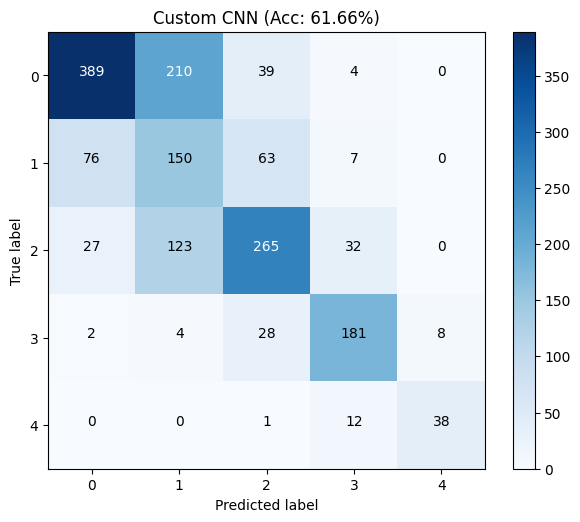

Loading /kaggle/input/models/best_model_alex.pth...

--- Evaluating AlexNet ---
Accuracy: 0.6076
              precision    recall  f1-score   support

           0     0.6565    0.8037    0.7227       642
           1     0.2634    0.2162    0.2375       296
           2     0.6319    0.4877    0.5505       447
           3     0.7345    0.7444    0.7394       223
           4     0.7458    0.8627    0.8000        51

    accuracy                         0.6076      1659
   macro avg     0.6064    0.6230    0.6100      1659
weighted avg     0.5930    0.6076    0.5943      1659



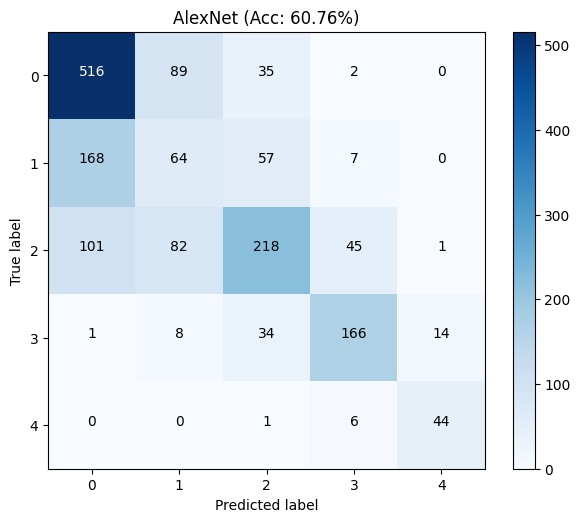

Loading /kaggle/input/models/densenet121_best.pth...

--- Evaluating DenseNet121 (ImageNet) ---
Accuracy: 0.6944
              precision    recall  f1-score   support

           0     0.7678    0.8551    0.8091       642
           1     0.3587    0.3818    0.3699       296
           2     0.7352    0.5839    0.6509       447
           3     0.8296    0.8296    0.8296       223
           4     0.8627    0.8627    0.8627        51

    accuracy                         0.6944      1659
   macro avg     0.7108    0.7026    0.7044      1659
weighted avg     0.6973    0.6944    0.6925      1659



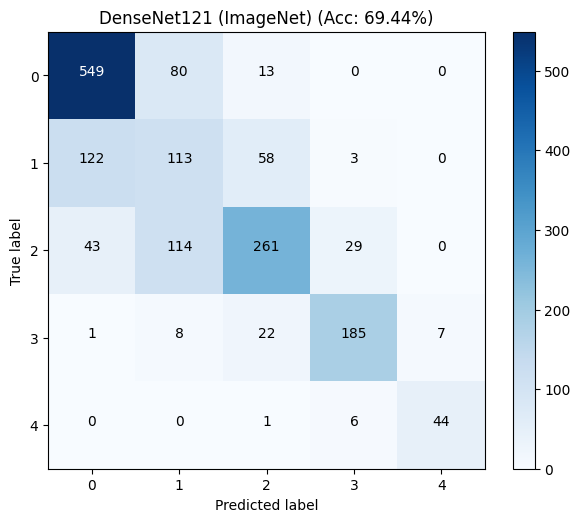

Loading /kaggle/input/models/best_model_txv.pth...

--- Evaluating TorchXRayVision ---
Accuracy: 0.6516
              precision    recall  f1-score   support

           0     0.7166    0.8193    0.7645       642
           1     0.3299    0.3243    0.3271       296
           2     0.6859    0.5324    0.5995       447
           3     0.7617    0.8027    0.7817       223
           4     0.8077    0.8235    0.8155        51

    accuracy                         0.6516      1659
   macro avg     0.6604    0.6605    0.6577      1659
weighted avg     0.6482    0.6516    0.6459      1659



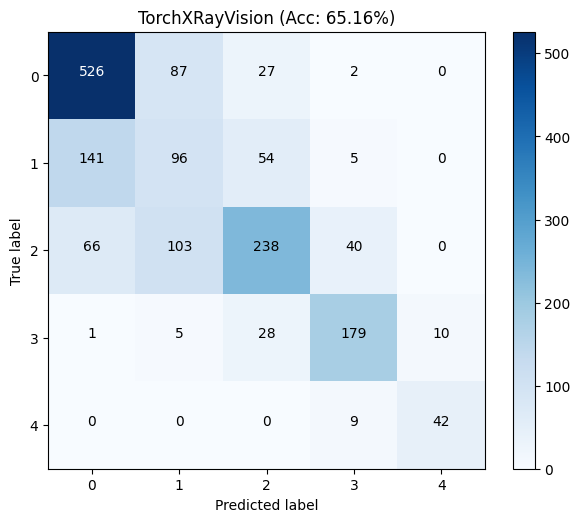


=== FINAL LEADERBOARD ===
                    Model  Accuracy  Macro F1
2  DenseNet121 (ImageNet)  0.694394  0.704448
3         TorchXRayVision  0.651597  0.657662
0              Custom CNN  0.616637  0.653777
1                 AlexNet  0.607595  0.610018


In [8]:
results = []

# 1. Custom CNN (Grayscale)
model_cnn = CustomCNN(5)
model_cnn = load_weights(model_cnn, '/kaggle/input/models/best_model_cnn.pth')
res = evaluate_and_plot(model_cnn, loader_gray, "Custom CNN")
if res: results.append(res)

# 2. AlexNet (Grayscale)
model_alex = AlexNet_KOA(5)
model_alex = load_weights(model_alex, '/kaggle/input/models/best_model_alex.pth')
res = evaluate_and_plot(model_alex, loader_gray, "AlexNet")
if res: results.append(res)

# 3. DenseNet ImageNet (RGB + Normalized) <-- CRITICAL: Uses loader_rgb
model_dense = get_densenet(5)
model_dense = load_weights(model_dense, '/kaggle/input/models/densenet121_best.pth')
res = evaluate_and_plot(model_dense, loader_rgb, "DenseNet121 (ImageNet)")
if res: results.append(res)

# 4. TorchXRayVision (Grayscale)
model_txv = get_txv_model(5)
model_txv = load_weights(model_txv, '/kaggle/input/models/best_model_txv.pth')
res = evaluate_and_plot(model_txv, loader_gray, "TorchXRayVision")
if res: results.append(res)

# Final Comparison
if results:
    df = pd.DataFrame(results).sort_values(by='Macro F1', ascending=False)
    print("\n=== FINAL LEADERBOARD ===")
    print(df)